In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

from prepare import remove_outliers, tts, scale_wine
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
#loading the data
white=pd.read_csv('winequality-white.csv')
red=pd.read_csv('winequality-red.csv')

#assigning the color column to each dataframe
red['color']= 'red'
white['color']= 'white'

#concatinating the two dataframes into one
wine= pd.concat([red, white], ignore_index=True)

#removing outliers
wine, fences=remove_outliers(wine)

#scaling numeric data
wine=scale_wine(wine)

#get dummies for color
wine=pd.get_dummies(wine, columns=['color'])

#splitting into train validate and test sets
train, val, test= tts(wine, 'quality')

quality column ignored
color column ignored


In [3]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
2383,0.510204,0.260870,0.267857,0.775148,0.447917,0.600000,0.718045,0.784500,0.385542,0.492063,0.107143,5,0,1
2388,0.591837,0.382609,0.410714,0.591716,0.312500,0.386667,0.424812,0.750510,0.566265,0.126984,0.160714,6,0,1
5347,0.306122,0.278261,0.375000,0.704142,0.479167,0.600000,0.481203,0.711761,0.602410,0.460317,0.107143,5,0,1
5635,0.530612,0.434783,0.321429,0.047337,0.333333,0.506667,0.642857,0.391570,0.409639,0.412698,0.267857,5,0,1
4923,0.448980,0.156522,0.464286,0.082840,0.395833,0.146667,0.417293,0.299796,0.433735,0.460317,0.571429,6,0,1


# Andy cluster model

In [4]:
#setting values to cluster by
X=train[['chlorides', 'residual sugar']]
V=val[['chlorides', 'residual sugar']]
#making, fitting, and predicting clusters
kmeans = KMeans(n_clusters=4, random_state=8675309)
kmeans.fit(X)

train['rs_chl_cluster']=kmeans.predict(X)
val['rs_chl_cluster']=kmeans.predict(V)

In [5]:
#separating into x and y
x_train= train.drop(columns=['quality', 'chlorides', 'residual sugar'])
y_train= train['quality']

x_val= val.drop(columns=['quality', 'chlorides', 'residual sugar'])
y_val= val['quality']

x_test= test.drop(columns=['quality', 'chlorides', 'residual sugar'])
y_test= test['quality']

In [6]:
#establishing baseline accuracy

#making base column
train['base']= 6

#making the confusion matrix with actual quality  and baseline
cm= confusion_matrix(y_train, train['base'])

#computing the accuracy
#tn, fp, fn, tp= cm.ravel()

#accuracy = (tp+tn) / (tn+fp+fn+tp)
#accuracy
cm

array([[   0,    0,    0,    5,    0,    0,    0],
       [   0,    0,    0,   85,    0,    0,    0],
       [   0,    0,    0,  825,    0,    0,    0],
       [   0,    0,    0, 1298,    0,    0,    0],
       [   0,    0,    0,  505,    0,    0,    0],
       [   0,    0,    0,   91,    0,    0,    0],
       [   0,    0,    0,    4,    0,    0,    0]])

In [7]:
print(classification_report(y_train,train['base']))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        85
           5       0.00      0.00      0.00       825
           6       0.46      1.00      0.63      1298
           7       0.00      0.00      0.00       505
           8       0.00      0.00      0.00        91
           9       0.00      0.00      0.00         4

    accuracy                           0.46      2813
   macro avg       0.07      0.14      0.09      2813
weighted avg       0.21      0.46      0.29      2813



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
train=train.drop(columns=['base'])

In [9]:
metrics= []

for n in range(1, 21):
    for i in range(2, 21):
                                                    #build the model
        rm= RandomForestClassifier(max_depth= i,
                                         min_samples_leaf= n)
                                                    #fit the model
        rm.fit(x_train, y_train)
                                                    #get accuracy from in and out of sample data
        in_sample= rm.score(x_train, y_train)
        out_of_sample= rm.score(x_val, y_val)
                                                    #assigning the output to a dictionary
        output={
            'max_depth': i,
            'min_samples_leaf': n,
            'train_accuracy': in_sample,
            'validate_accuracy': out_of_sample
        }
                                                    #appending the output dictionary to the empty metrics list
        metrics.append(output)

In [10]:
metrics=pd.DataFrame(data=metrics)

In [11]:
metrics['difference']=metrics['train_accuracy']-metrics['validate_accuracy']

In [12]:
metrics.head().sort_values(by='difference', ascending=True)

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,difference
0,2,1,0.517241,0.499171,0.018071
1,3,1,0.547458,0.518242,0.029216
2,4,1,0.573765,0.533997,0.039768
3,5,1,0.594739,0.533997,0.060742
4,6,1,0.622467,0.548922,0.073545


# Barts cluster model

In [19]:
train=train.drop(columns=['rs_chl_cluster'])
val=val.drop(columns=['rs_chl_cluster'])

In [20]:
seed = 8675309
X=train[['fixed acidity', 'volatile acidity']]
V=val[['fixed acidity', 'volatile acidity']]
kmeans= KMeans(n_clusters = 3, random_state = seed)

kmeans.fit(X)

train['bart_cluster']=kmeans.predict(X)
val['bart_cluster']=kmeans.predict(V)

In [21]:
#separating into x and y
x_train= train.drop(columns=['quality', 'fixed acidity', 'volatile acidity'])
y_train= train['quality']

x_val= val.drop(columns=['quality', 'fixed acidity', 'volatile acidity'])
y_val= val['quality']

x_test= test.drop(columns=['quality', 'fixed acidity', 'volatile acidity'])
y_test= test['quality']

In [22]:
x_train.head()

,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color_red,color_white,bart_cluster
2383,0.267857,0.775148,0.447917,0.600000,0.718045,0.784500,0.385542,0.492063,0.107143,0,1,0
2388,0.410714,0.591716,0.312500,0.386667,0.424812,0.750510,0.566265,0.126984,0.160714,0,1,0
5347,0.375000,0.704142,0.479167,0.600000,0.481203,0.711761,0.602410,0.460317,0.107143,0,1,2
5635,0.321429,0.047337,0.333333,0.506667,0.642857,0.391570,0.409639,0.412698,0.267857,0,1,0
4923,0.464286,0.082840,0.395833,0.146667,0.417293,0.299796,0.433735,0.460317,0.571429,0,1,2


In [23]:
metrics= []

for n in range(1, 21):
    for i in range(2, 21):
                                                    #build the model
        rm= RandomForestClassifier(max_depth= i,
                                         min_samples_leaf= n)
                                                    #fit the model
        rm.fit(x_train, y_train)
                                                    #get accuracy from in and out of sample data
        in_sample= rm.score(x_train, y_train)
        out_of_sample= rm.score(x_val, y_val)
                                                    #assigning the output to a dictionary
        output={
            'max_depth': i,
            'min_samples_leaf': n,
            'train_accuracy': in_sample,
            'validate_accuracy': out_of_sample
        }
                                                    #appending the output dictionary to the empty metrics list
        metrics.append(output)

In [24]:
metrics=pd.DataFrame(data=metrics)
metrics['difference']=metrics['train_accuracy']-metrics['validate_accuracy']
metrics.head().sort_values(by='difference', ascending=True)

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,difference
0,2,1,0.489157,0.476783,0.012375
1,3,1,0.532883,0.503317,0.029566
2,4,1,0.568788,0.525705,0.043083
3,5,1,0.602560,0.558043,0.044516
4,6,1,0.638464,0.565506,0.072958


# Bart or Andy cluster combo

In [25]:
#setting values to cluster by
X=train[['chlorides', 'residual sugar']]
V=val[['chlorides', 'residual sugar']]
#making, fitting, and predicting clusters
kmeans = KMeans(n_clusters=4, random_state=8675309)
kmeans.fit(X)

train['rs_chl_cluster']=kmeans.predict(X)
val['rs_chl_cluster']=kmeans.predict(V)

In [26]:
#separating into x and y
x_train= train.drop(columns=['quality', 'fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar'])
y_train= train['quality']

x_val= val.drop(columns=['quality', 'fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar'])
y_val= val['quality']

x_test= test.drop(columns=['quality', 'fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar'])
y_test= test['quality']

In [27]:
x_train.head()

,citric acid,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color_red,color_white,bart_cluster,rs_chl_cluster
2383,0.267857,0.600000,0.718045,0.784500,0.385542,0.492063,0.107143,0,1,0,1
2388,0.410714,0.386667,0.424812,0.750510,0.566265,0.126984,0.160714,0,1,0,2
5347,0.375000,0.600000,0.481203,0.711761,0.602410,0.460317,0.107143,0,1,2,1
5635,0.321429,0.506667,0.642857,0.391570,0.409639,0.412698,0.267857,0,1,0,0
4923,0.464286,0.146667,0.417293,0.299796,0.433735,0.460317,0.571429,0,1,2,0


In [28]:
metrics= []

for n in range(1, 21):
    for i in range(2, 21):
                                                    #build the model
        rm= RandomForestClassifier(max_depth= i,
                                         min_samples_leaf= n)
                                                    #fit the model
        rm.fit(x_train, y_train)
                                                    #get accuracy from in and out of sample data
        in_sample= rm.score(x_train, y_train)
        out_of_sample= rm.score(x_val, y_val)
                                                    #assigning the output to a dictionary
        output={
            'max_depth': i,
            'min_samples_leaf': n,
            'train_accuracy': in_sample,
            'validate_accuracy': out_of_sample
        }
                                                    #appending the output dictionary to the empty metrics list
        metrics.append(output)

In [29]:
metrics=pd.DataFrame(data=metrics)
metrics['difference']=metrics['train_accuracy']-metrics['validate_accuracy']
metrics.head().sort_values(by='difference', ascending=True)

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,difference
0,2,1,0.507288,0.480100,0.027188
1,3,1,0.528973,0.500000,0.028973
2,4,1,0.571632,0.525705,0.045927
3,5,1,0.595450,0.543118,0.052332
4,6,1,0.628866,0.548922,0.079944


# no cluster engineered features

In [32]:
train=train.drop(columns=['rs_chl_cluster', 'bart_cluster'])
val=val.drop(columns=['rs_chl_cluster', 'bart_cluster'])

In [4]:
#separating into x and y
x_train= train.drop(columns=['quality'])
y_train= train['quality']

x_val= val.drop(columns=['quality'])
y_val= val['quality']

x_test= test.drop(columns=['quality'])
y_test= test['quality']

In [5]:
x_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color_red,color_white
2383,0.510204,0.260870,0.267857,0.775148,0.447917,0.600000,0.718045,0.784500,0.385542,0.492063,0.107143,0,1
2388,0.591837,0.382609,0.410714,0.591716,0.312500,0.386667,0.424812,0.750510,0.566265,0.126984,0.160714,0,1
5347,0.306122,0.278261,0.375000,0.704142,0.479167,0.600000,0.481203,0.711761,0.602410,0.460317,0.107143,0,1
5635,0.530612,0.434783,0.321429,0.047337,0.333333,0.506667,0.642857,0.391570,0.409639,0.412698,0.267857,0,1
4923,0.448980,0.156522,0.464286,0.082840,0.395833,0.146667,0.417293,0.299796,0.433735,0.460317,0.571429,0,1


In [15]:
metrics= []

for n in range(1, 21):
    for i in range(2, 21):
                                                    #build the model
        rm= RandomForestClassifier(max_depth= i,
                                         min_samples_leaf= n, random_state=8675309)
                                                    #fit the model
        rm.fit(x_train, y_train)
                                                    #get accuracy from in and out of sample data
        in_sample= rm.score(x_train, y_train)
        out_of_sample= rm.score(x_val, y_val)
                                                    #assigning the output to a dictionary
        output={
            'max_depth': i,
            'min_samples_leaf': n,
            'train_accuracy': in_sample,
            'validate_accuracy': out_of_sample
        }
                                                    #appending the output dictionary to the empty metrics list
        metrics.append(output)

In [16]:
metrics=pd.DataFrame(data=metrics)
metrics['difference']=metrics['train_accuracy']-metrics['validate_accuracy']
metrics.head(10).sort_values(by='difference', ascending=True)

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,difference
0,2,1,0.525062,0.508292,0.016770
1,3,1,0.547103,0.524046,0.023056
2,4,1,0.574831,0.536484,0.038347
3,5,1,0.594383,0.543947,0.050436
4,6,1,0.633132,0.558043,0.075089
5,7,1,0.671881,0.575456,0.096425
6,8,1,0.723427,0.592869,0.130558
7,9,1,0.779950,0.610282,0.169668
8,10,1,0.848560,0.628524,0.220036
9,11,1,0.908638,0.650912,0.257726


# Run test set

In [7]:
metrics= []
rm= RandomForestClassifier(max_depth= 3, min_samples_leaf= 1, random_state=8675309)
rm.fit(x_train, y_train)
in_sample= rm.score(x_train, y_train)
out_of_sample= rm.score(x_val, y_val)
test=rm.score(x_test, y_test)
output={'max_depth': 3,
        'min_samples_leaf': 1,
        'train_accuracy': in_sample,
        'validate_accuracy': out_of_sample,
        'test_accuracy': test
       }
metrics.append(output)
metrics=pd.DataFrame(data=metrics)
metrics

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,test_accuracy
0,3,1,0.547103,0.524046,0.513433


In [87]:
def model_info(train, val):
    
    #setting values to cluster by
    X=train[['chlorides', 'residual sugar']]
    V=val[['chlorides', 'residual sugar']]
    #making, fitting, and predicting clusters
    kmeans = KMeans(n_clusters=4, random_state=8675309)
    kmeans.fit(X)

    train['rs_chl_cluster']=kmeans.predict(X)
    val['rs_chl_cluster']=kmeans.predict(V)

    #separating into x and y
    x_train= train.drop(columns=['quality', 'chlorides', 'residual sugar'])
    y_train= train['quality']

    x_val= val.drop(columns=['quality', 'chlorides', 'residual sugar'])
    y_val= val['quality']

    metrics= []

                                                        #build the model
    rm= RandomForestClassifier(max_depth= 2, min_samples_leaf= 1, random_state=8675309)
                                                        #fit the model
    rm.fit(x_train, y_train)
                                                        #get accuracy from in and out of sample data
    in_sample= rm.score(x_train, y_train)
    out_of_sample= rm.score(x_val, y_val)
                                                        #assigning the output to a dictionary
    output={'max_depth': 2,
            'min_samples_leaf': 1,
            'train_accuracy': in_sample,
            'validate_accuracy': out_of_sample,
            'cluster': 'residual_sugar_and_chloride'
            }
                                                        #appending the output dictionary to the empty metrics list
    metrics.append(output)

    train=train.drop(columns=['rs_chl_cluster'])
    val=val.drop(columns=['rs_chl_cluster'])
    ############################################################################################
    seed = 8675309
    X=train[['fixed acidity', 'volatile acidity']]
    V=val[['fixed acidity', 'volatile acidity']]
    kmeans= KMeans(n_clusters = 3, random_state = seed)

    kmeans.fit(X)

    train['bart_cluster']=kmeans.predict(X)
    val['bart_cluster']=kmeans.predict(V)

    #separating into x and y
    x_train= train.drop(columns=['quality', 'fixed acidity', 'volatile acidity'])
    y_train= train['quality']

    x_val= val.drop(columns=['quality', 'fixed acidity', 'volatile acidity'])
    y_val= val['quality']


                                                        #build the model
    rm= RandomForestClassifier(max_depth= 2, min_samples_leaf= 1)
                                                        #fit the model
    rm.fit(x_train, y_train)
                                                        #get accuracy from in and out of sample data
    in_sample= rm.score(x_train, y_train)
    out_of_sample= rm.score(x_val, y_val)
                                                        #assigning the output to a dictionary
    output={
        'max_depth': 2,
        'min_samples_leaf': 1,
        'train_accuracy': in_sample,
        'validate_accuracy': out_of_sample,
        'cluster': 'fixed_acidity_and_volatile_acidity'
    }
                                                        #appending the output dictionary to the empty metrics list
    metrics.append(output)

    ###################################################################################

    #setting values to cluster by
    X=train[['chlorides', 'residual sugar']]
    V=val[['chlorides', 'residual sugar']]
    #making, fitting, and predicting clusters
    kmeans = KMeans(n_clusters=4, random_state=8675309)
    kmeans.fit(X)

    train['rs_chl_cluster']=kmeans.predict(X)
    val['rs_chl_cluster']=kmeans.predict(V)

    #separating into x and y
    x_train= train.drop(columns=['quality', 'fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar'])
    y_train= train['quality']

    x_val= val.drop(columns=['quality', 'fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar'])
    y_val= val['quality']


                                                        #build the model
    rm= RandomForestClassifier(max_depth= 2, min_samples_leaf= 1, random_state=seed)
                                                        #fit the model
    rm.fit(x_train, y_train)
                                                        #get accuracy from in and out of sample data
    in_sample= rm.score(x_train, y_train)
    out_of_sample= rm.score(x_val, y_val)
                                                        #assigning the output to a dictionary
    output={
        'max_depth': 2,
        'min_samples_leaf': 1,
        'train_accuracy': in_sample,
        'validate_accuracy': out_of_sample,
        'cluster': 'both'
    }
                                                        #appending the output dictionary to the empty metrics list
    metrics.append(output)

    #############################################################################################

    train=train.drop(columns=['rs_chl_cluster', 'bart_cluster'])
    val=val.drop(columns=['rs_chl_cluster', 'bart_cluster'])

    #separating into x and y
    x_train= train.drop(columns=['quality'])
    y_train= train['quality']

    x_val= val.drop(columns=['quality'])
    y_val= val['quality']

                                                        #build the model
    rm= RandomForestClassifier(max_depth= 3, min_samples_leaf= 1, random_state=8675309)
                                                        #fit the model
    rm.fit(x_train, y_train)
                                                        #get accuracy from in and out of sample data
    in_sample= rm.score(x_train, y_train)
    out_of_sample= rm.score(x_val, y_val)
                                                        #assigning the output to a dictionary
    output={
        'max_depth': 3,
        'min_samples_leaf': 1,
        'train_accuracy': in_sample,
        'validate_accuracy': out_of_sample,
        'cluster': 'none'
    }
                                                        #appending the output dictionary to the empty metrics list
    metrics.append(output)
    metrics=pd.DataFrame(data=metrics)
    metrics['difference']=metrics['train_accuracy']-metrics['validate_accuracy']
    return metrics

In [88]:
metrics= model_info(train, val)
metrics

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,cluster,difference
0,2,1,0.517597,0.489221,residual_sugar_and_chloride,0.028376
1,2,1,0.505866,0.485904,fixed_acidity_and_volatile_acidity,0.019962
2,2,1,0.507643,0.482587,both,0.025056
3,3,1,0.547103,0.519900,none,0.027202


In [83]:
def model_viz(df):
    plt.figure(figsize=(10,10))
    X = ['Cluster 1','Cluster 2','Both','None']
    trainacc = df['train_accuracy']
    valacc = df['validate_accuracy']
    diff= df['difference']
  
    X_axis = np.arange(len(X))
  
    plt.bar(X_axis - 0.2, trainacc, 0.4, label = 'Train Accuracy', color=['blue'], ec='black')
    plt.bar(X_axis + 0.2, valacc, 0.4, label = 'Validate Accuracy', color=['green'], ec='black')
  
    plt.xticks(X_axis, X)
    plt.xlabel("Model Includes")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of Models")
    plt.ylim(0,.7)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend()
    plt.show()

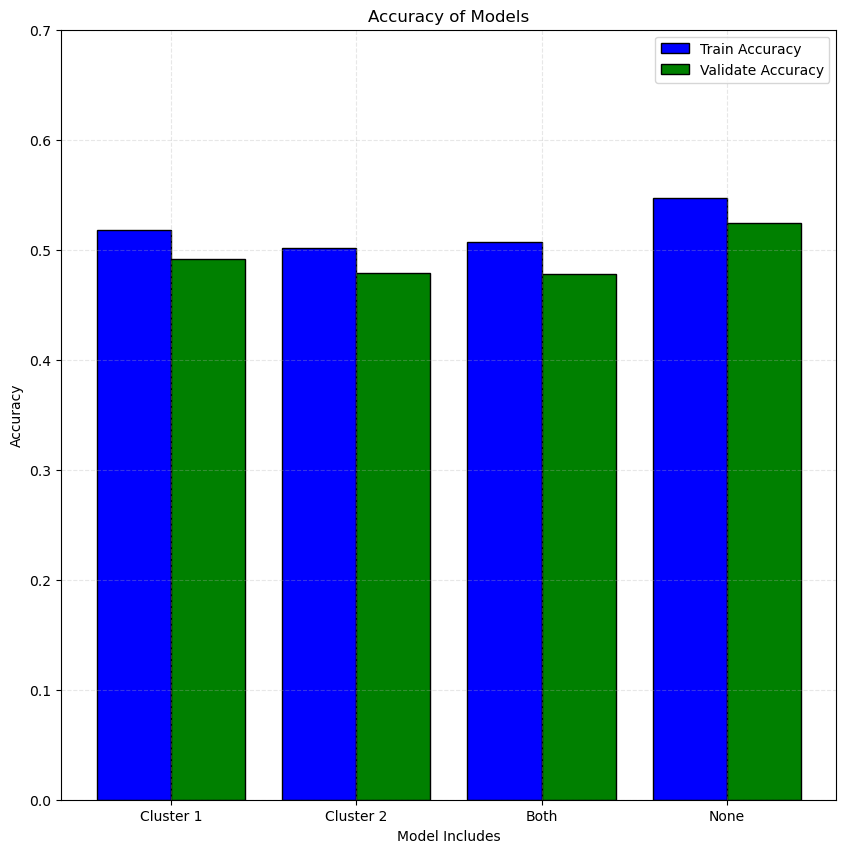

In [84]:
model_viz(metrics)